In [3]:
import igraph as ig
import numpy as np
import os
from collections import Counter, defaultdict, OrderedDict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
from auxiliar_optimization import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [5]:
### Select dataset
DATASET = "am" # ["amz", "um", "am"]
PROJ_NAMES = ["simple", "jaccard", "neighs", "hyper", "resall"]

nombre_proyecciones = {
    "simple": "Weighted", "jaccard": "Jaccard", "hyper": "Hyperbolic",
    "vector": "Vectorized", "resall": "Resource\nAllocation", "neighs": "Neighborhood"
}
nombre_backbonings = { "NC": "Noise Corrected", "DF": "Disparity Filter"}
COLORS_PR = ["#ef476fff", "#f78c6bff", "#ffd166ff", "#06d6a0ff", "#118ab2ff", "#718355"]
COLORS_BB = [ "#8ab17d", "#e9c46a"]
COLORS_SV = ["#718355", "#87986a", "#97a97c", "#b5c99a"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "am/actor-movie.graphml"
    
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


In [1]:
# Auxiliar functions
def plot_pie_subplots(proyecciones, backbonings, significancias, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    categories = [
        (proyecciones, "Projections types"),
        (backbonings, "Backboning methods"),
        (OrderedDict(sorted(significancias.items(), key=lambda x: float(x[0]))), "Significance value")
    ]
    color_counter = 0
    for ax, (data, subtitle) in zip(axes, categories):
        labels = list(data.keys())
        sizes = list(data.values())

        if color_counter == 0:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_PR)
        elif color_counter == 1:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_BB)
        else:
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=COLORS_SV)
        color_counter += 1
        ax.set_title(subtitle)
        ax.axis('equal')

    fig.suptitle(f"Distribution of network instance characteristics - {title}", fontsize=14)
    plt.tight_layout()
    plt.savefig(title + "-pastel.png")
    plt.show()

# Función principal
def analizar_frente(front, nombre="Frente"):
    proyecciones = Counter()
    backbonings = Counter()
    significancias = Counter()

    for sol in front:
        if isinstance(sol, dict):
            fname = sol["filename"]
        else:
            fname = sol

        parts = fname.split("_")
        if len(parts) == 3:
            proj, back, alpha = parts

            proj_label = nombre_proyecciones.get(proj, proj)
            back_label = nombre_backbonings.get(back, back)

            proyecciones[proj_label] += 1
            backbonings[back_label] += 1

            if alpha.startswith('a'):
                alpha_val = alpha[1:]
                if len(alpha_val) == 1:
                    alpha_val = f"0.{alpha_val}0"
                elif len(alpha_val) == 2:
                    alpha_val = f"0.{alpha_val}"
                else:
                    alpha_val = f"0.{alpha_val[:2]}"
                significancias[alpha_val] += 1

    print(f"\nResumen para {nombre}")
    print("Proyecciones:", dict(proyecciones))
    print("Backbonings:", dict(backbonings))
    print("Significancias:", dict(significancias))

    # Mostrar los subplots
    plot_pie_subplots(proyecciones, backbonings, significancias, nombre)

### Mapa de figuras, colores, y líneas.

projection_styles = {
    "simple": "tab:blue",
    "jaccard": "tab:orange",
    "neighs": "tab:green",
    "hyper": "tab:red",
    "resall": "tab:purple",
    "vector": "tab:brown"
}


backboning_styles = {
    "DF": "-",    # línea continua
    "NC": "--"    # línea punteada
}

alpha_styles = {
    "a05": "o",   # círculo
    "a1": "s",   # cuadrado
    "a15": "*",   # rombo
    "a2": "^"    # triángulo
}

projection_labels = {
    "simple": "Simple",
    "jaccard": "Jaccard",
    "vector": "Vectorized",
    "neighs": "Neighborhood",
    "hyper": "Hyperbolic",
    "resall": "Resource Allocation"
}

backboning_labels = {
    "DF": "Disparity Filter",
    "NC": "Noise Corrected"
}

alpha_labels = {
    "a05": "0.05",
    "a1": "0.10",
    "a15": "0.15",
    "a2": "0.20"
}

backboning_styles2 = { 'DF': "full", 'NC': "none"}

### Load dataset

In [6]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH UN-T 511463 1470404 -- 
+ attr: id (v), name (v), type (v)

|U|= 383640  	|R|= 127823  	|U|+|R|= 511463 = 511463

The graph IS bipartite


### Apply projection and backboning

In [7]:
for proj_opcion in PROJ_NAMES:
    ###### ****** Projections ****** ######
    top_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), False) # False = Users = 0
    print("Done PROJ1 - Users Projection")
    edges_temp = top_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")

    bot_graph = apply_projection(g, proj_opcion,
                                len(top_nodes), True) # True = Resources = 1
    print("\nDone PROJ2 - Resources Projection")
    edges_temp = bot_graph.es()["weight"]
    print(f"Peso máximo={max(edges_temp)} y mínimo={min(edges_temp)} en aristas: ")
    print()

    ### Applying backboning
    for i, graph_type in enumerate([top_graph, bot_graph]):
        apply_backboning(graph_type, dataset=DATASET, proj_opcion=proj_opcion, nodetype=i, remove_zeros=False)
    

Done PROJ1 - Users Projection
Peso máximo=216 y mínimo=1 en aristas: 

Done PROJ2 - Resources Projection
Peso máximo=69 y mínimo=1 en aristas: 


##### **** BACKBONING USERS **** #####
Projection Name: simple
Summary
 IGRAPH UNWT 383640 15038083 -- 
+ attr: id (v), name (v), type (v), weight (e)
##### END #####

Peso máximo=216 y mínimo=1 en aristas: 

Factor de escala: 1
Peso máximo=216 y mínimo=1 en aristas: 

TOP DF - time: 5.1926708221 seconds.
Grafo filtrado con alpha=0.05: IGRAPH UNWT 380191 85601 -- 
+ attr: id (v), name (v), type (v), weight (e)
Grafo filtrado con alpha=0.1: IGRAPH UNWT 383032 207378 -- 
+ attr: id (v), name (v), type (v), weight (e)
Grafo filtrado con alpha=0.15: IGRAPH UNWT 383481 404348 -- 
+ attr: id (v), name (v), type (v), weight (e)
Grafo filtrado con alpha=0.2: IGRAPH UNWT 383481 754540 -- 
+ attr: id (v), name (v), type (v), weight (e)
TOP NC - time: 13.5070812702 seconds.
Grafo filtrado con alpha=0.05: IGRAPH UNWT 383640 14963570 -- 
+ attr: id (v), n

## Top type 0 Optimization

In [7]:
NODETYPE = 0    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics

KeyboardInterrupt: 

In [8]:
import random

def average_local_bipartite_clustering_coefficient2(graph, U_type_value=False, k=None):
    """
    Calculates the average local clustering coefficient for a random sample of k
    nodes in a bipartite graph.

    Args:
        graph: An igraph Graph object. Must be bipartite with a 'type' vertex attribute.
        U_type_value: The boolean value (True/False) that indicates the partition
                      for which to calculate the average clustering coefficient.
        k: The number of nodes to sample randomly. If None, the function
           calculates the coefficient for all nodes in the partition.

    Returns:
        The average local clustering coefficient for the sampled set of k nodes.
    """
    if not graph.is_bipartite():
        raise ValueError("Graph must be bipartite.")
    if "type" not in graph.vs.attributes():
        raise ValueError("Bipartite graph must have a 'type' vertex attribute.")

    # Get all vertices in set U
    U_vertices_ids = [v.index for v in graph.vs if v["type"] == U_type_value]

    if not U_vertices_ids:
        return 0.0

    # If k is specified, sample k nodes randomly from the U_vertices_ids list
    if k is not None and k < len(U_vertices_ids):
        # The random.sample() function is efficient and ensures unique samples.
        sampled_U_vertices_ids = random.sample(U_vertices_ids, k)
    else:
        # If k is None or larger than the list, use all nodes
        sampled_U_vertices_ids = U_vertices_ids

    sum_cc_u = 0.0
    for u_id in sampled_U_vertices_ids:
        # NOTE: You'll need to make sure the local_bipartite_clustering_coefficient
        # function is also defined and available in your script.
        sum_cc_u += local_bipartite_clustering_coefficient(graph, u_id, U_type_value)

    if not sampled_U_vertices_ids:
        return 0.0

    return sum_cc_u / len(sampled_U_vertices_ids)

In [11]:
average_local_bipartite_clustering_coefficient2(gb, True, 100)

KeyboardInterrupt: 

In [10]:
NODETYPE = 0    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = {'x1': 383640,
 'x2': 127823,
 'x3': 1470404,
 'x8': 0.241,
 'x9': 7.113887200410482,
 'x11': 1.8623650345000595,
 'x15':gb.density(),
 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 383640,
 'x2': 127823,
 'x3': 1470404,
 'x8': 0.241,
 'x9': 7.113887200410482,
 'x11': 1.8623650345000595,
 'x15': 1.1241883410574385e-05,
 'x16': 3.832770305494735}

In [37]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")
proj_files = [f for f in os.listdir(proj_dir) if f.endswith(".graphml")]

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

solutions = []
to_df = []
names_df = []
k = 100  # For approximation

for fname in proj_files:
    graph_path = os.path.join(proj_dir, fname)
    gu = ig.Graph.Read_GraphML(graph_path)
    gu = remove_isolated_nodes(gu, k=5)

    # Nombre base del archivo (sin extensión)
    base_name = fname[:-8]
    cache_path = os.path.join(metrics_cache_dir, f"{base_name}_metrics.pkl")

    # Verificar si ya existe un archivo de métricas cacheado
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            proj_metrics = pickle.load(f)
    else:
        k_approx = min(k, gu.vcount())
        proj_metrics = compute_proj_metrics(gu, k_approx)
        with open(cache_path, 'wb') as f:
            pickle.dump(proj_metrics, f)

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(proj_files))
print("Feasible solutions:", len(solutions))


All solutions: 40
Feasible solutions: 20


In [12]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 40
Feasible solutions: 20



Frente 1 (19 soluciones):
jaccard_NC_a15
neighs_NC_a2
hyper_NC_a15
jaccard_NC_a05
resall_NC_a2
hyper_NC_a05
hyper_NC_a1
resall_NC_a05
hyper_NC_a2
resall_NC_a1
neighs_NC_a1
resall_NC_a15
jaccard_NC_a2
neighs_NC_a05
simple_NC_a1
simple_NC_a15
simple_NC_a2
simple_NC_a05
jaccard_NC_a1

Frente 2 (1 soluciones):
neighs_NC_a15

Resumen para AM Top
Proyecciones: {'Jaccard': 4, 'Neighborhood': 4, 'Hyperbolic': 4, 'Resource\nAllocation': 4, 'Weighted': 4}
Backbonings: {'Noise Corrected': 20}
Significancias: {'0.15': 5, '0.20': 5, '0.05': 5, '0.10': 5}


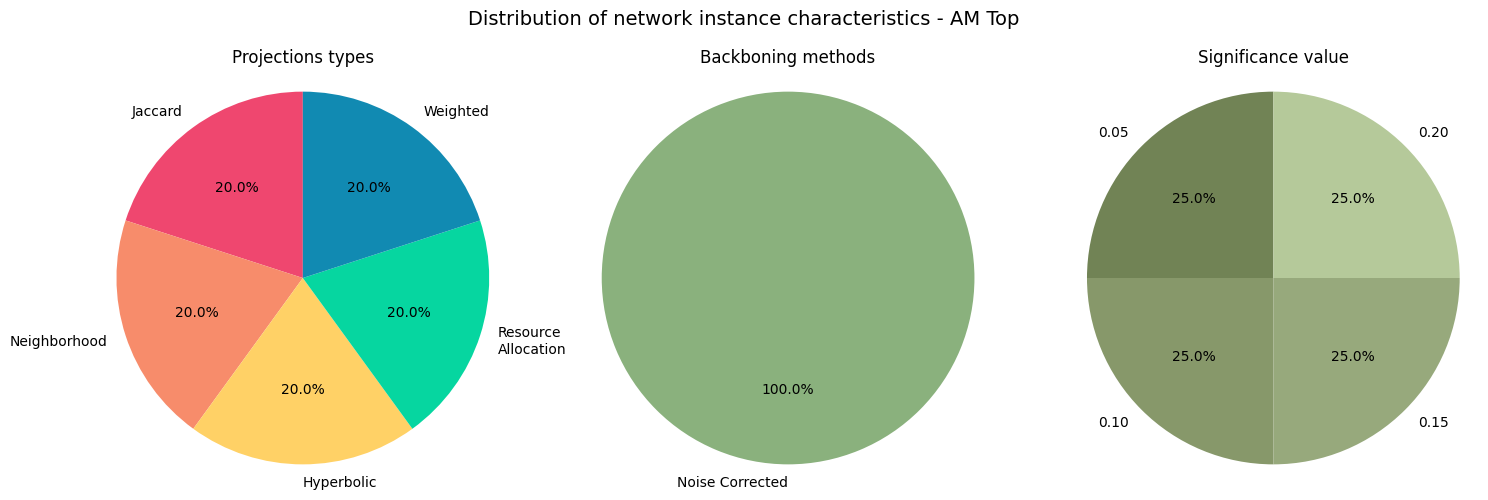

In [13]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][7:]
        print(clean_name)
        counter_sols.append(clean_name)

analizar_frente(counter_sols, DATASET.upper()+" Top")

In [10]:
cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))

Crowding 19


### Plotting

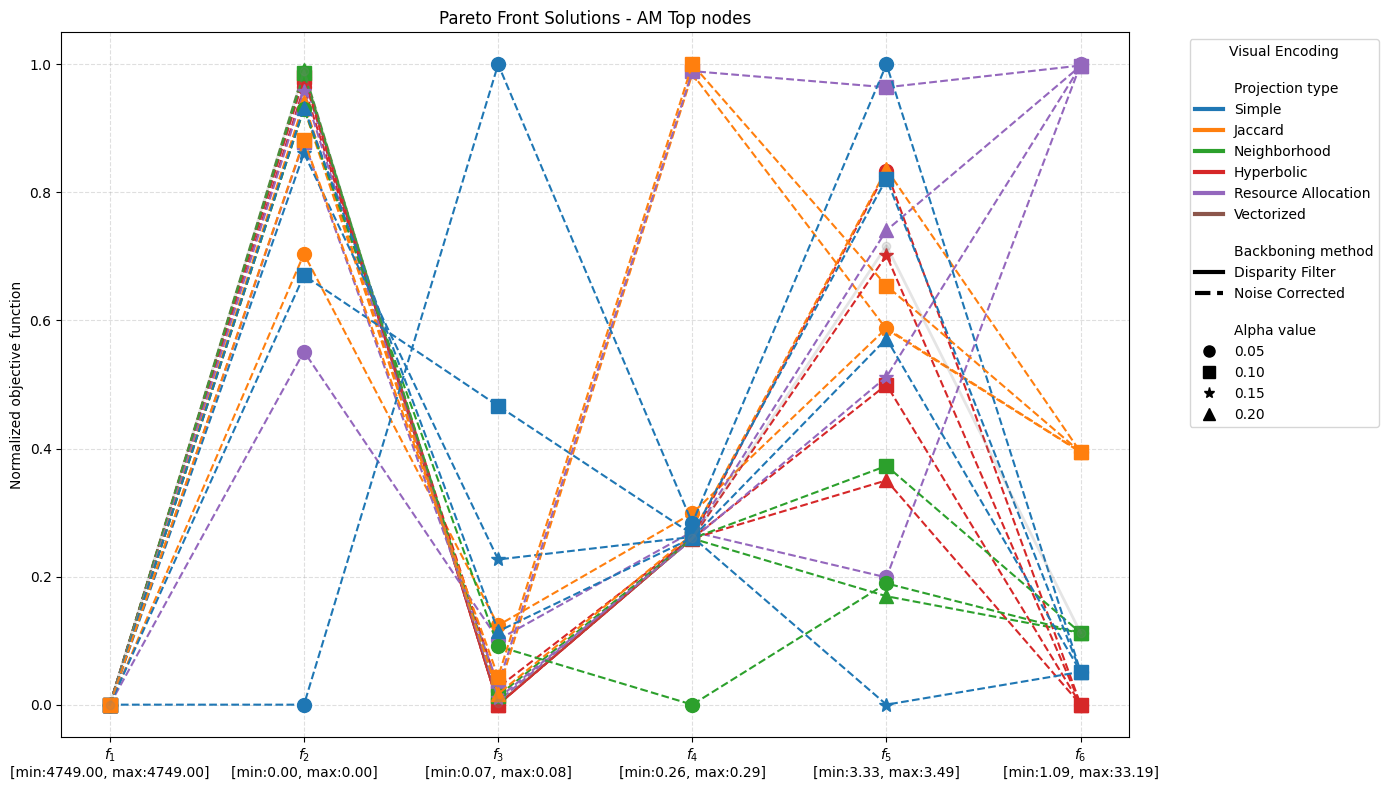

In [14]:
# --- Parallel Coordinates ---

labels = ["$f_1$", "$f_2$", "$f_3$", "$f_4$", "$f_5$", "$f_6$"]

# 1. Aplanar la lista de frentes para normalizar todos los datos juntos
todas_las_soluciones = [sol for front in all_fronts for sol in front]
F_all = np.array([sol["f"] for sol in todas_las_soluciones])

# 2. Calcular los valores mínimo y máximo de cada función objetivo
min_vals = F_all.min(axis=0)
max_vals = F_all.max(axis=0)

# 3. Normalizar todos los valores
F_norm_all = (F_all - min_vals) / (max_vals - min_vals + 1e-8)

# 4. Preparar la figura para la gráfica
plt.figure(figsize=(14, 8))

# Generar una escala de grises
num_frentes = len(all_fronts)
# Usar `np.linspace` para generar valores de gris desde un tono oscuro a uno claro.
# Por ejemplo, desde un gris 0.2 (oscuro) hasta 0.8 (claro).
gray_scale = np.linspace(0.2, 0.8, num_frentes+1)

# 5. Recorrer los frentes y las soluciones para graficar
idx_solucion = 0
for i, front in enumerate(all_fronts):
    rank = i + 1
    num_sols = len(front)

    # Asignar el color del frente
    if i == 0:
        color = "tomato"
    else:
        color = str(gray_scale[i])

    # Generar nombres de soluciones (puedes ajustar esto si tus soluciones tienen un identificador propio)
    nombres_soluciones = [sol.get("filename", f"sol_{idx_solucion + j}") for j, sol in enumerate(front)]
    nombres_soluciones = [i[8:] for i in nombres_soluciones]
    nombres_mostrados = ",\n- ".join(nombres_soluciones[:5])


    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion]

        name_code = sol["filename"].split("_")[2:]
        stl_proj = projection_styles[name_code[0]]
        stl_bb = backboning_styles[name_code[1]]
        stl_a = alpha_styles[name_code[2]] 

        # Solo la primera solución del frente tiene leyenda
        label = None

        if i == 0:
            plt.plot(
                labels,
                F_norm_solucion,
                color=stl_proj,
                linestyle=stl_bb,
                linewidth=1.5,
                marker=stl_a,
                label=label,
                ms=10
            )
        else:
            plt.plot(
                labels,
                F_norm_solucion,
                color=color,
                linestyle="-",
                linewidth=2,
                marker="o",
                label=label,
                alpha=0.2             
            )
        
        idx_solucion += 1


# 6. Actualizar las etiquetas del eje X con los rangos de valores reales
new_labels = [f"{lbl}\n[min:{min_v:.2f}, max:{max_v:.2f}]" for lbl, min_v, max_v in zip(labels, min_vals, max_vals)]
plt.xticks(range(len(new_labels)), new_labels, rotation=0)

# 7. Configurar y guardar la gráfica
plt.ylabel("Normalized objective function")

if NODETYPE == 0:
    plt.title("Pareto Front Solutions - " + DATASET.upper() + " Top nodes")
else:
    plt.title("Pareto Front Solutions - " + DATASET.upper() + " Bot nodes")
plt.grid(True, linestyle="--", alpha=0.4)

from matplotlib.lines import Line2D

# --- Crear handles personalizados para la leyenda ---

color_handles = [
    Line2D([0], [0], color=projection_styles[key], lw=3, label=projection_labels[key])
    for key in projection_styles
]

line_handles = [
    Line2D([0], [0], color='black', linestyle=backboning_styles[key], lw=3, label=backboning_labels[key])
    for key in backboning_styles
]

marker_handles = [
    Line2D([0], [0], color='black', marker=alpha_styles[key], linestyle='None', markersize=8, label=alpha_labels[key])
    for key in alpha_styles
]

# 4. Combinar todos los handles
custom_legend = (
    [Line2D([0], [0], color='white', label='\nProjection type')] + color_handles +
    [Line2D([0], [0], color='white', label='\nBackboning method')] + line_handles +
    [Line2D([0], [0], color='white', label='\nAlpha value')] + marker_handles
)

# 5. Mostrar la leyenda personalizada
plt.legend(handles=custom_legend, title="Visual Encoding", bbox_to_anchor=(1.05, 1), loc="upper left")


#plt.legend(title="Pareto Fronts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-pf.png")
plt.show()


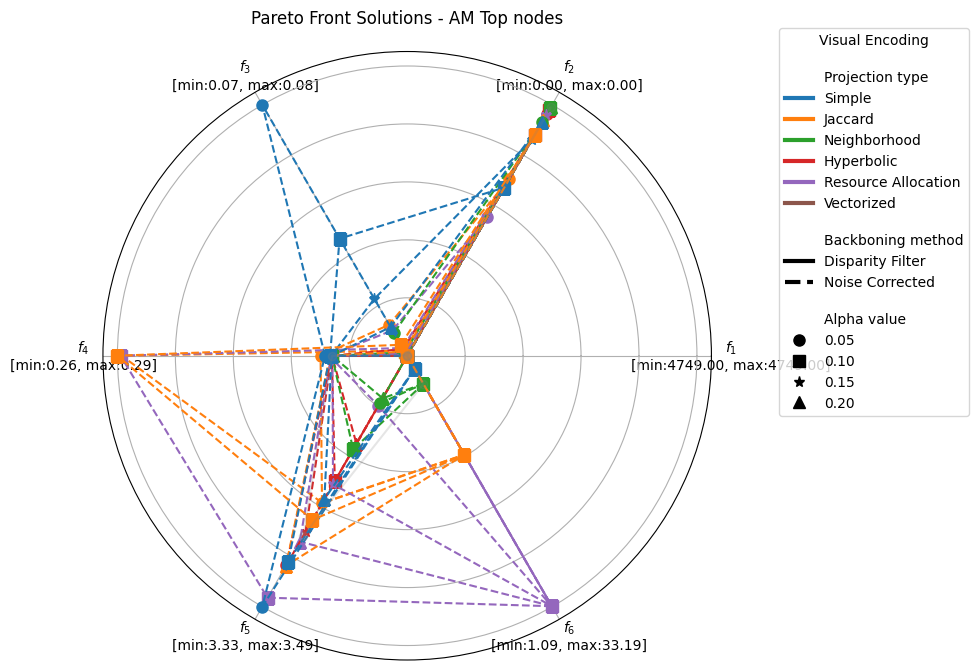

In [15]:
# --- Radar ---

# 1. Preparar figura radar
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# 2. Ángulos y etiquetas
N = len(labels)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]
labels += labels[:1]

# 3. Escala de grises para frentes secundarios
num_frentes = len(all_fronts)
gray_scale = np.linspace(0.2, 0.8, num_frentes + 1)

# 4. Recorrer soluciones
idx_solucion = 0
for i, front in enumerate(all_fronts):
    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion].tolist()
        F_norm_solucion += F_norm_solucion[:1]

        name_code = sol["filename"].split("_")[2:]
        key_proj, key_bb, key_alpha = name_code

        stl_proj = projection_styles[key_proj]
        stl_bb = backboning_styles[key_bb]
        stl_a = alpha_styles[key_alpha]

        if i == 0:
            ax.plot(
                angles,
                F_norm_solucion,
                color=stl_proj,
                linestyle=stl_bb,
                linewidth=1.5,
                marker=stl_a,
                label=None,
                markersize=8
            )
        else:
            ax.plot(
                angles,
                F_norm_solucion,
                color=str(gray_scale[i]),
                linestyle="-",
                linewidth=1.5,
                marker="o",
                alpha=0.2,
                label=None
            )

        idx_solucion += 1

# 5. Etiquetas de los ejes
ax.set_xticks(angles[:-1])
ax.set_xticklabels([
    f"{lbl}\n[min:{min_v:.2f}, max:{max_v:.2f}]"
    for lbl, min_v, max_v in zip(labels[:-1], min_vals, max_vals)
])
ax.set_yticklabels([])
#ax.set_title(f"Comparison of Pareto Front Solutions - {DATASET.upper()} Bot", pad=20)
if NODETYPE == 0:
    ax.set_title("Pareto Front Solutions - " + DATASET.upper() + " Top nodes", pad=20)
else:
    ax.set_title("Pareto Front Solutions - " + DATASET.upper() + " Bot nodes", pad=20)

# 6. Leyenda personalizada
color_handles = [
    Line2D([0], [0], color=projection_styles[key], lw=3, label=projection_labels[key])
    for key in projection_styles
]

line_handles = [
    Line2D([0], [0], color='black', linestyle=backboning_styles[key], lw=3, label=backboning_labels[key])
    for key in backboning_styles
]

marker_handles = [
    Line2D([0], [0], color='black', marker=alpha_styles[key], linestyle='None', markersize=8, label=alpha_labels[key])
    for key in alpha_styles
]

custom_legend = (
    [Line2D([0], [0], color='white', label='\nProjection type')] + color_handles +
    [Line2D([0], [0], color='white', label='\nBackboning method')] + line_handles +
    [Line2D([0], [0], color='white', label='\nAlpha value')] + marker_handles
)

plt.legend(handles=custom_legend, title="Visual Encoding", bbox_to_anchor=(1.1, 1.05), loc="upper left")
plt.tight_layout()
plt.savefig(f"{DATASET}-Type{NODETYPE}-pf-radar.png")
plt.show()


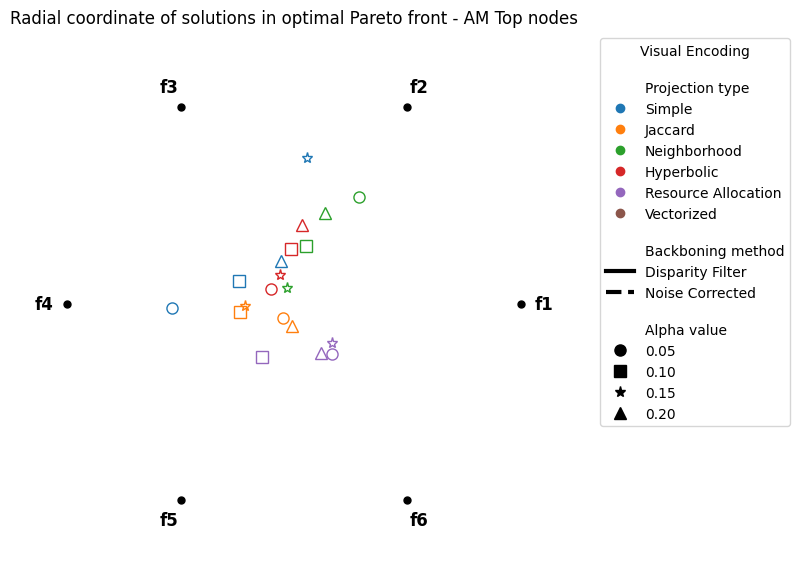

In [16]:
# --- Radial Coordinates ---

# 1. Crear DataFrame con datos normalizados
df = pd.DataFrame(F_norm_all, columns=["f1", "f2", "f3", "f4", "f5", "f6"])

# 2. Agregar columna de clase (frente)
clases = []
idx_solucion = 0
for i, front in enumerate(all_fronts):
    clases.extend([f"Front {i+1}"] * len(front))
    idx_solucion += len(front)
df["Front"] = clases

# 3. Calcular anclas de Radviz
features = df.columns[:-1]
n_features = len(features)
anchors = np.array([
    [np.cos(2 * np.pi * i / n_features), np.sin(2 * np.pi * i / n_features)]
    for i in range(n_features)
])
anchors_df = pd.DataFrame(anchors, index=features, columns=["x", "y"])

# 4. Calcular posición de cada punto
def radviz_position(row):
    row = row[features]
    row_sum = row.sum()
    if row_sum == 0:
        return np.zeros(2)
    weighted = (anchors_df.T * row).T
    return weighted.sum().values / row_sum

positions = df.apply(radviz_position, axis=1)
df["x"] = [p[0] for p in positions]
df["y"] = [p[1] for p in positions]

# 5. Graficar con estilo personalizado
plt.figure(figsize=(8, 8))
ax = plt.gca()

idx_solucion = 0
for i, front in enumerate(all_fronts):
    for sol in front:
        name_code = sol["filename"].split("_")[2:]
        key_proj, key_bb, key_alpha = name_code

        color = projection_styles[key_proj]
        marker = alpha_styles[key_alpha]
        fillstyle_ = backboning_styles2[key_bb]  # 'full' o 'none'

        x = df.loc[idx_solucion, "x"]
        y = df.loc[idx_solucion, "y"]

        ax.plot(
            x, y,
            marker=marker,
            color=color,
            markersize=8,
            linestyle='None',
            markerfacecolor=color,
            markeredgecolor=color,
            markerfacecoloralt='none',
            fillstyle=fillstyle_
        )

        idx_solucion += 1

# 6. Anclas de atributos
for i, (x, y) in enumerate(anchors):
    ax.text(x * 1.1, y * 1.1, features[i], ha='center', va='center', fontsize=12, weight='bold')
    ax.plot(x, y, 'ko', markersize=5)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axis('off')

if NODETYPE == 0:
    plt.title(f"Radial coordinate of solutions in optimal Pareto front - {DATASET.upper()} Top nodes")
else:
    plt.title(f"Radial coordinate of solutions in optimal Pareto front - {DATASET.upper()} Bot nodes")

# 7. Leyenda personalizada
from matplotlib.lines import Line2D

color_handles = [
    Line2D([0], [0], color=projection_styles[key], marker='o', linestyle='None', label=projection_labels[key])
    for key in projection_styles
]

marker_handles = [
    Line2D([0], [0], color='black', marker=alpha_styles[key], linestyle='None', markersize=8, label=alpha_labels[key])
    for key in alpha_styles
]

fill_handles = [
    Line2D([0], [0], color='black', marker='o', linestyle='None',
           markerfacecolor='black',
           fillstyle=fill, label=backboning_labels[key])
    for key, fill in backboning_styles2.items()
]

custom_legend = (
    [Line2D([0], [0], color='white', label='\nProjection type')] + color_handles +
    [Line2D([0], [0], color='white', label='\nBackboning method')] + line_handles +
    [Line2D([0], [0], color='white', label='\nAlpha value')] + marker_handles
)

plt.legend(handles=custom_legend, title="Visual Encoding", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(f"{DATASET}-Type{NODETYPE}-pf-radviz.png")
plt.show()


### Plotting Dimensinality Reduction

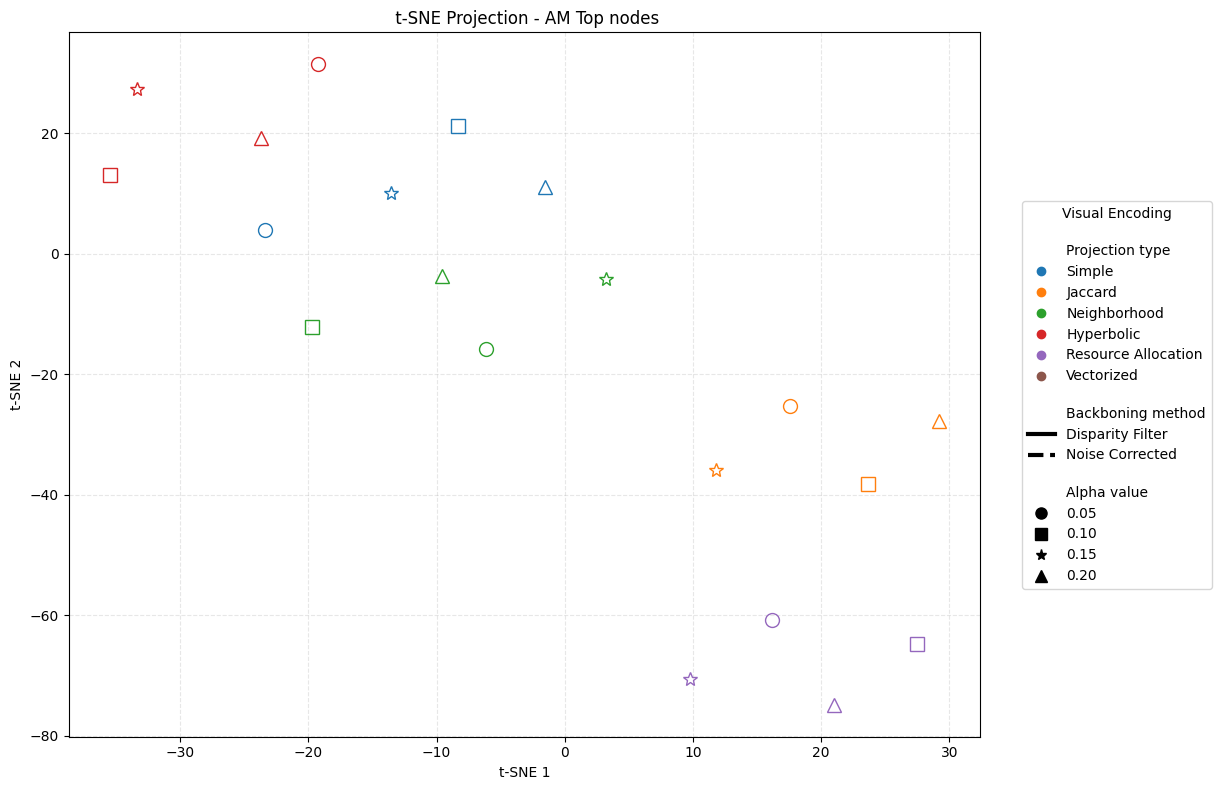

In [17]:
# --- TSNE ---

points = []
labels = []
name_codes = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)
        name_codes.append(sol["filename"].split("_")[2:])  # [proj, bb, alpha]

points = np.array(points)
labels = np.array(labels)

# 2. Aplicar t-SNE solo en 2D
tsne_2d = TSNE(n_components=2, perplexity=10, random_state=1, init='pca', learning_rate='auto')
embedding_2d = tsne_2d.fit_transform(points)

# 3. Crear figura
fig, ax1 = plt.subplots(figsize=(10, 8))

# 4. Graficar 2D con estilo personalizado
for i, (x, y) in enumerate(embedding_2d):
    key_proj, key_bb, key_alpha = name_codes[i]
    color = projection_styles[key_proj]
    marker = alpha_styles[key_alpha]
    fillstyle = backboning_styles2[key_bb]

    ax1.plot(
        x, y,
        marker=marker,
        color=color,
        markersize=10,
        linestyle='None',
        markerfacecolor=color if fillstyle == 'full' else 'none',
        markeredgecolor=color,
        markerfacecoloralt='none',
        fillstyle=fillstyle
    )

if NODETYPE == 0:
    #plt.title(f"Radviz Visualization of Pareto Fronts - {DATASET.upper()} Bot")
    plt.title(" t-SNE Projection - " + DATASET.upper() + " Top nodes")
else:
    plt.title(" t-SNE Projection - " + DATASET.upper() + " Bot nodes")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.grid(True, linestyle="--", alpha=0.3)

# 5. Leyenda personalizada
color_handles = [
    Line2D([0], [0], color=projection_styles[key], marker='o', linestyle='None', label=projection_labels[key])
    for key in projection_styles
]

marker_handles = [
    Line2D([0], [0], color='black', marker=alpha_styles[key], linestyle='None', markersize=8, label=alpha_labels[key])
    for key in alpha_styles
]

fill_handles = [
    Line2D([0], [0], color='black', marker='o', linestyle='None',
           markerfacecolor='black' if fill == 'full' else 'none',
           fillstyle=fill, label=backboning_labels[key])
    for key, fill in backboning_styles2.items()
]

custom_legend = (
    [Line2D([0], [0], color='white', label='\nProjection type')] + color_handles +
    [Line2D([0], [0], color='white', label='\nBackboning method')] + line_handles +
    [Line2D([0], [0], color='white', label='\nAlpha value')] + marker_handles
)


fig.legend(handles=custom_legend, title="Visual Encoding", bbox_to_anchor=(1.02, 0.5), loc="center left")
plt.tight_layout()
plt.savefig(f"{DATASET}-Type{NODETYPE}-tsne.png")
plt.show()


## Optimization type 0

In [18]:
NODETYPE = 1    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = compute_bip_metrics(gb, NODETYPE)
bip_metrics

KeyboardInterrupt: 

In [19]:
NODETYPE = 1    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = {'x1': 383640,
 'x2': 127823,
 'x3': 1470404,
 'x8': 0.242,
 'x9': 7.234182993236018,
 'x11': 5.066327861107771,
 'x15':gb.density(),
 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 383640,
 'x2': 127823,
 'x3': 1470404,
 'x8': 0.242,
 'x9': 7.234182993236018,
 'x11': 5.066327861107771,
 'x15': 1.1241883410574385e-05,
 'x16': 11.503438348341065}

In [31]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")
proj_files = [f for f in os.listdir(proj_dir) if f.endswith(".graphml")]

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

solutions = []
to_df = []
names_df = []
k = 100  # For approximation

for fname in proj_files:
    graph_path = os.path.join(proj_dir, fname)
    gu = ig.Graph.Read_GraphML(graph_path)
    gu = remove_isolated_nodes(gu, k=5)

    # Nombre base del archivo (sin extensión)
    base_name = fname[:-8]
    cache_path = os.path.join(metrics_cache_dir, f"{base_name}_metrics.pkl")

    # Verificar si ya existe un archivo de métricas cacheado
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            proj_metrics = pickle.load(f)
    else:
        k_approx = min(k, gu.vcount())
        proj_metrics = compute_proj_metrics(gu, k_approx)
        with open(cache_path, 'wb') as f:
            pickle.dump(proj_metrics, f)

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(proj_files))
print("Feasible solutions:", len(solutions))


All solutions: 40
Feasible solutions: 26


In [20]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 40
Feasible solutions: 26



Frente 1 (24 soluciones):
hyper_NC_a2
jaccard_NC_a05
simple_NC_a15
resall_DF_a15
neighs_NC_a1
jaccard_NC_a1
resall_DF_a05
jaccard_NC_a15
simple_NC_a05
simple_DF_a2
resall_NC_a1
neighs_NC_a15
resall_NC_a2
jaccard_NC_a2
neighs_NC_a2
neighs_NC_a05
hyper_NC_a1
resall_NC_a05
resall_NC_a15
simple_DF_a15
resall_DF_a1
simple_NC_a2
simple_NC_a1
resall_DF_a2

Frente 2 (2 soluciones):
hyper_NC_a05
hyper_NC_a15

Resumen para AM Bot
Proyecciones: {'Hyperbolic': 4, 'Jaccard': 4, 'Weighted': 6, 'Resource\nAllocation': 8, 'Neighborhood': 4}
Backbonings: {'Noise Corrected': 20, 'Disparity Filter': 6}
Significancias: {'0.20': 7, '0.05': 6, '0.15': 7, '0.10': 6}


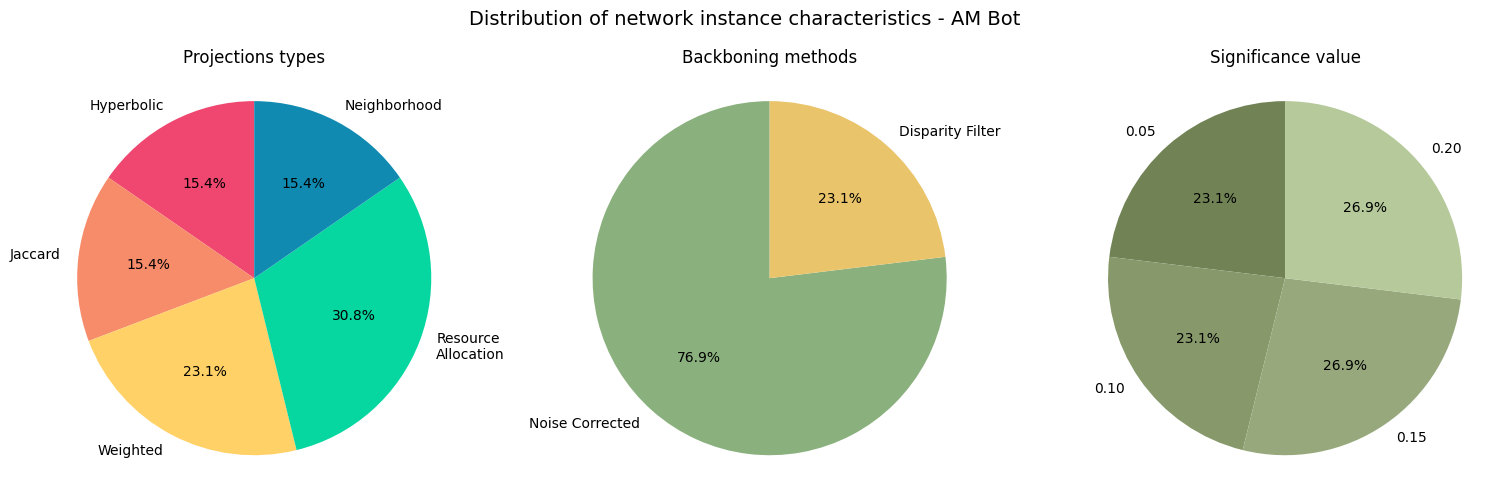

In [21]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][7:]
        print(clean_name)
        counter_sols.append(clean_name)

analizar_frente(counter_sols, DATASET.upper()+" Bot")

In [23]:
cd = crowding_distance(all_fronts[0])
pareto_sorted = [s for _, s in sorted(zip(-cd, all_fronts[0]), key=lambda x: x[0])]
print("Crowding", len(pareto_sorted))

Crowding 24


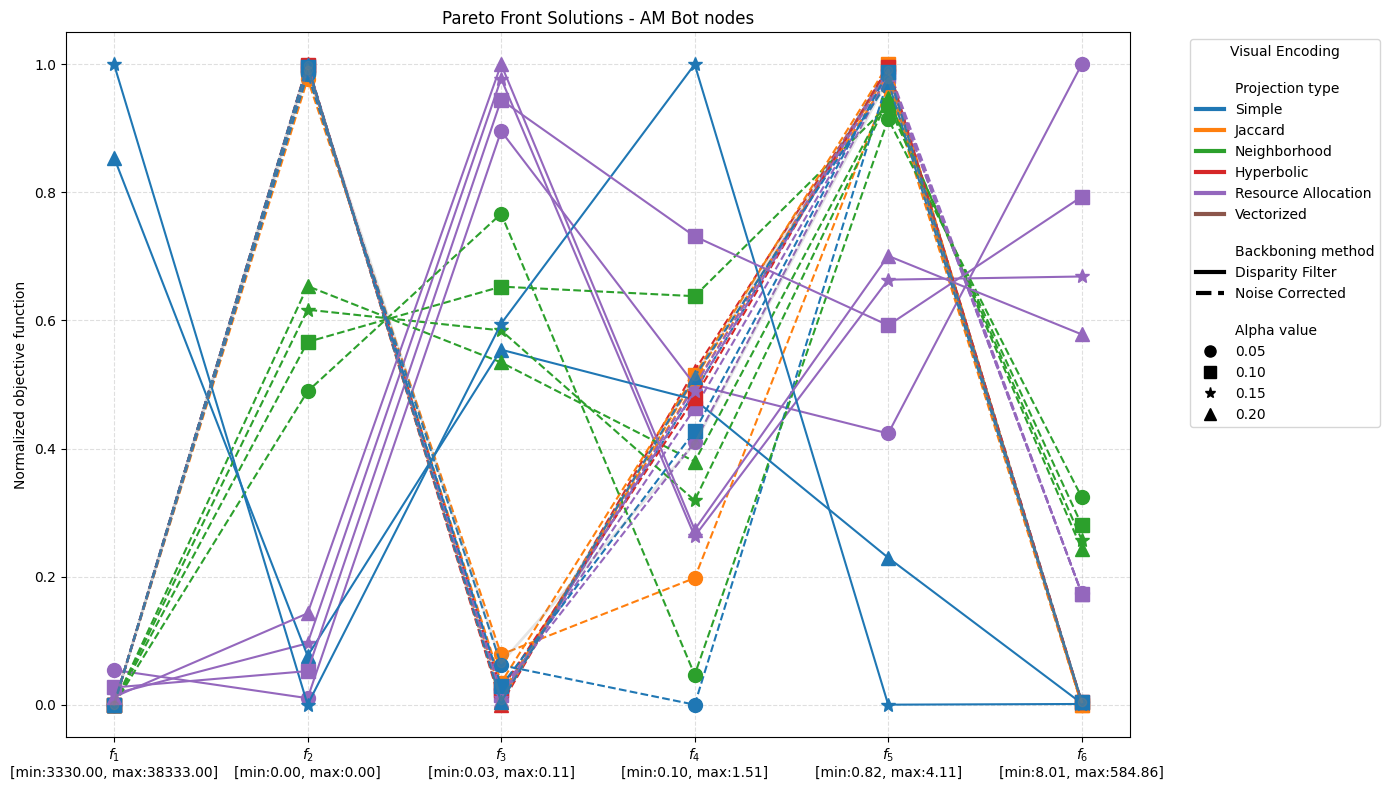

In [22]:
# --- Parallel Coordinates ---

labels = ["$f_1$", "$f_2$", "$f_3$", "$f_4$", "$f_5$", "$f_6$"]

# 1. Aplanar la lista de frentes para normalizar todos los datos juntos
todas_las_soluciones = [sol for front in all_fronts for sol in front]
F_all = np.array([sol["f"] for sol in todas_las_soluciones])

# 2. Calcular los valores mínimo y máximo de cada función objetivo
min_vals = F_all.min(axis=0)
max_vals = F_all.max(axis=0)

# 3. Normalizar todos los valores
F_norm_all = (F_all - min_vals) / (max_vals - min_vals + 1e-8)

# 4. Preparar la figura para la gráfica
plt.figure(figsize=(14, 8))

# Generar una escala de grises
num_frentes = len(all_fronts)
# Usar `np.linspace` para generar valores de gris desde un tono oscuro a uno claro.
# Por ejemplo, desde un gris 0.2 (oscuro) hasta 0.8 (claro).
gray_scale = np.linspace(0.2, 0.8, num_frentes+1)

# 5. Recorrer los frentes y las soluciones para graficar
idx_solucion = 0
for i, front in enumerate(all_fronts):
    rank = i + 1
    num_sols = len(front)

    # Asignar el color del frente
    if i == 0:
        color = "tomato"
    else:
        color = str(gray_scale[i])

    # Generar nombres de soluciones (puedes ajustar esto si tus soluciones tienen un identificador propio)
    nombres_soluciones = [sol.get("filename", f"sol_{idx_solucion + j}") for j, sol in enumerate(front)]
    nombres_soluciones = [i[8:] for i in nombres_soluciones]
    nombres_mostrados = ",\n- ".join(nombres_soluciones[:5])


    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion]

        name_code = sol["filename"].split("_")[2:]
        stl_proj = projection_styles[name_code[0]]
        stl_bb = backboning_styles[name_code[1]]
        stl_a = alpha_styles[name_code[2]] 

        # Solo la primera solución del frente tiene leyenda
        label = None

        if i == 0:
            plt.plot(
                labels,
                F_norm_solucion,
                color=stl_proj,
                linestyle=stl_bb,
                linewidth=1.5,
                marker=stl_a,
                label=label,
                ms=10
            )
        else:
            plt.plot(
                labels,
                F_norm_solucion,
                color=color,
                linestyle="-",
                linewidth=2,
                marker="o",
                label=label,
                alpha=0.2             
            )
        
        idx_solucion += 1


# 6. Actualizar las etiquetas del eje X con los rangos de valores reales
new_labels = [f"{lbl}\n[min:{min_v:.2f}, max:{max_v:.2f}]" for lbl, min_v, max_v in zip(labels, min_vals, max_vals)]
plt.xticks(range(len(new_labels)), new_labels, rotation=0)

# 7. Configurar y guardar la gráfica
plt.ylabel("Normalized objective function")

if NODETYPE == 0:
    plt.title("Pareto Front Solutions - " + DATASET.upper() + " Top nodes")
else:
    plt.title("Pareto Front Solutions - " + DATASET.upper() + " Bot nodes")
plt.grid(True, linestyle="--", alpha=0.4)

from matplotlib.lines import Line2D

# --- Crear handles personalizados para la leyenda ---

color_handles = [
    Line2D([0], [0], color=projection_styles[key], lw=3, label=projection_labels[key])
    for key in projection_styles
]

line_handles = [
    Line2D([0], [0], color='black', linestyle=backboning_styles[key], lw=3, label=backboning_labels[key])
    for key in backboning_styles
]

marker_handles = [
    Line2D([0], [0], color='black', marker=alpha_styles[key], linestyle='None', markersize=8, label=alpha_labels[key])
    for key in alpha_styles
]

# 4. Combinar todos los handles
custom_legend = (
    [Line2D([0], [0], color='white', label='\nProjection type')] + color_handles +
    [Line2D([0], [0], color='white', label='\nBackboning method')] + line_handles +
    [Line2D([0], [0], color='white', label='\nAlpha value')] + marker_handles
)

# 5. Mostrar la leyenda personalizada
plt.legend(handles=custom_legend, title="Visual Encoding", bbox_to_anchor=(1.05, 1), loc="upper left")


#plt.legend(title="Pareto Fronts", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(DATASET+"-Type"+str(NODETYPE)+"-pf.png")
plt.show()


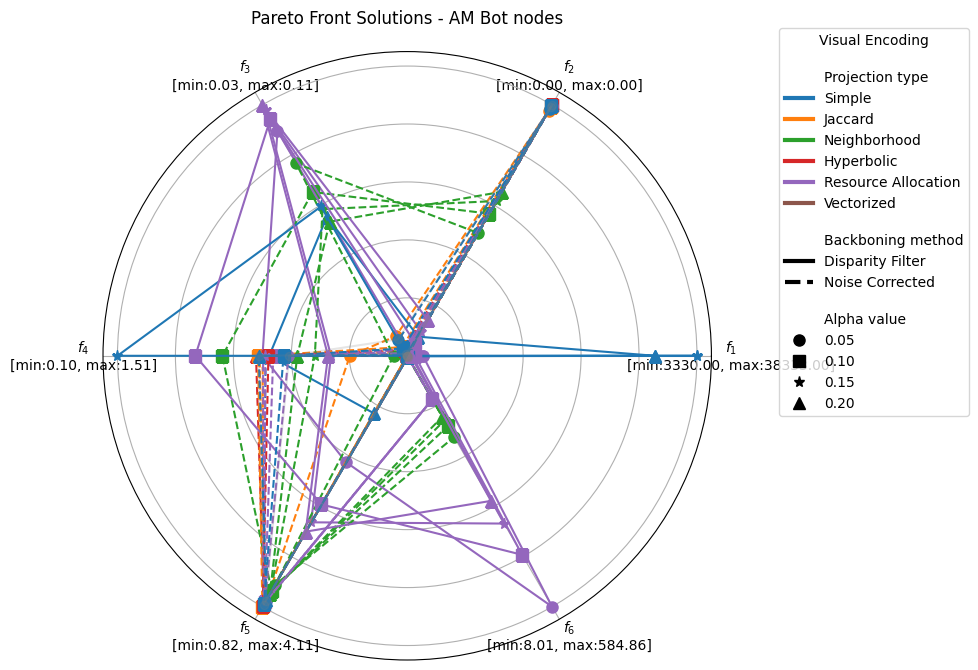

In [23]:
# --- Radar ---

# 1. Preparar figura radar
plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

# 2. Ángulos y etiquetas
N = len(labels)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]
labels += labels[:1]

# 3. Escala de grises para frentes secundarios
num_frentes = len(all_fronts)
gray_scale = np.linspace(0.2, 0.8, num_frentes + 1)

# 4. Recorrer soluciones
idx_solucion = 0
for i, front in enumerate(all_fronts):
    for j, sol in enumerate(front):
        F_norm_solucion = F_norm_all[idx_solucion].tolist()
        F_norm_solucion += F_norm_solucion[:1]

        name_code = sol["filename"].split("_")[2:]
        key_proj, key_bb, key_alpha = name_code

        stl_proj = projection_styles[key_proj]
        stl_bb = backboning_styles[key_bb]
        stl_a = alpha_styles[key_alpha]

        if i == 0:
            ax.plot(
                angles,
                F_norm_solucion,
                color=stl_proj,
                linestyle=stl_bb,
                linewidth=1.5,
                marker=stl_a,
                label=None,
                markersize=8
            )
        else:
            ax.plot(
                angles,
                F_norm_solucion,
                color=str(gray_scale[i]),
                linestyle="-",
                linewidth=1.5,
                marker="o",
                alpha=0.2,
                label=None
            )

        idx_solucion += 1

# 5. Etiquetas de los ejes
ax.set_xticks(angles[:-1])
ax.set_xticklabels([
    f"{lbl}\n[min:{min_v:.2f}, max:{max_v:.2f}]"
    for lbl, min_v, max_v in zip(labels[:-1], min_vals, max_vals)
])
ax.set_yticklabels([])
#ax.set_title(f"Comparison of Pareto Front Solutions - {DATASET.upper()} Bot", pad=20)
if NODETYPE == 0:
    ax.set_title("Pareto Front Solutions - " + DATASET.upper() + " Top nodes", pad=20)
else:
    ax.set_title("Pareto Front Solutions - " + DATASET.upper() + " Bot nodes", pad=20)

# 6. Leyenda personalizada
color_handles = [
    Line2D([0], [0], color=projection_styles[key], lw=3, label=projection_labels[key])
    for key in projection_styles
]

line_handles = [
    Line2D([0], [0], color='black', linestyle=backboning_styles[key], lw=3, label=backboning_labels[key])
    for key in backboning_styles
]

marker_handles = [
    Line2D([0], [0], color='black', marker=alpha_styles[key], linestyle='None', markersize=8, label=alpha_labels[key])
    for key in alpha_styles
]

custom_legend = (
    [Line2D([0], [0], color='white', label='\nProjection type')] + color_handles +
    [Line2D([0], [0], color='white', label='\nBackboning method')] + line_handles +
    [Line2D([0], [0], color='white', label='\nAlpha value')] + marker_handles
)

plt.legend(handles=custom_legend, title="Visual Encoding", bbox_to_anchor=(1.1, 1.05), loc="upper left")
plt.tight_layout()
plt.savefig(f"{DATASET}-Type{NODETYPE}-pf-radar.png")
plt.show()


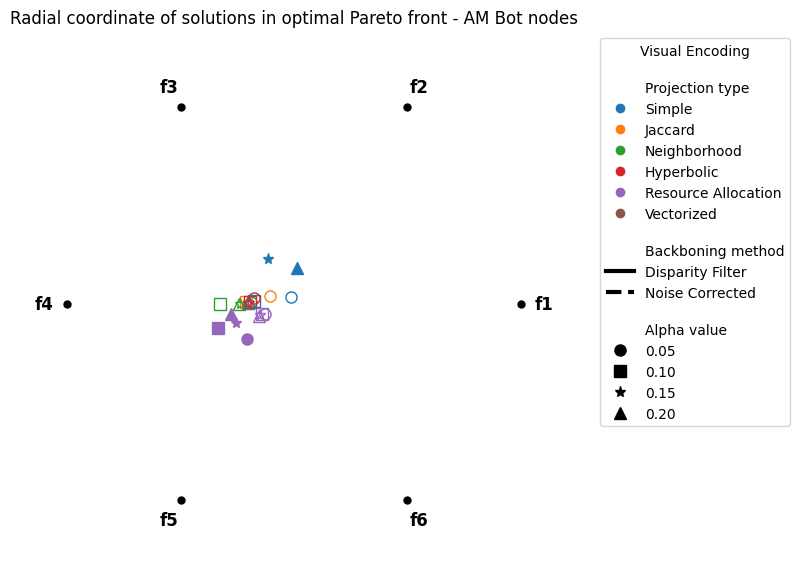

In [24]:
# --- Radial Coordinates ---

# 1. Crear DataFrame con datos normalizados
df = pd.DataFrame(F_norm_all, columns=["f1", "f2", "f3", "f4", "f5", "f6"])

# 2. Agregar columna de clase (frente)
clases = []
idx_solucion = 0
for i, front in enumerate(all_fronts):
    clases.extend([f"Front {i+1}"] * len(front))
    idx_solucion += len(front)
df["Front"] = clases

# 3. Calcular anclas de Radviz
features = df.columns[:-1]
n_features = len(features)
anchors = np.array([
    [np.cos(2 * np.pi * i / n_features), np.sin(2 * np.pi * i / n_features)]
    for i in range(n_features)
])
anchors_df = pd.DataFrame(anchors, index=features, columns=["x", "y"])

# 4. Calcular posición de cada punto
def radviz_position(row):
    row = row[features]
    row_sum = row.sum()
    if row_sum == 0:
        return np.zeros(2)
    weighted = (anchors_df.T * row).T
    return weighted.sum().values / row_sum

positions = df.apply(radviz_position, axis=1)
df["x"] = [p[0] for p in positions]
df["y"] = [p[1] for p in positions]

# 5. Graficar con estilo personalizado
plt.figure(figsize=(8, 8))
ax = plt.gca()

idx_solucion = 0
for i, front in enumerate(all_fronts):
    for sol in front:
        name_code = sol["filename"].split("_")[2:]
        key_proj, key_bb, key_alpha = name_code

        color = projection_styles[key_proj]
        marker = alpha_styles[key_alpha]
        fillstyle_ = backboning_styles2[key_bb]  # 'full' o 'none'

        x = df.loc[idx_solucion, "x"]
        y = df.loc[idx_solucion, "y"]

        ax.plot(
            x, y,
            marker=marker,
            color=color,
            markersize=8,
            linestyle='None',
            markerfacecolor=color,
            markeredgecolor=color,
            markerfacecoloralt='none',
            fillstyle=fillstyle_
        )

        idx_solucion += 1

# 6. Anclas de atributos
for i, (x, y) in enumerate(anchors):
    ax.text(x * 1.1, y * 1.1, features[i], ha='center', va='center', fontsize=12, weight='bold')
    ax.plot(x, y, 'ko', markersize=5)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axis('off')

if NODETYPE == 0:
    plt.title(f"Radial coordinate of solutions in optimal Pareto front - {DATASET.upper()} Top nodes")
else:
    plt.title(f"Radial coordinate of solutions in optimal Pareto front - {DATASET.upper()} Bot nodes")

# 7. Leyenda personalizada
from matplotlib.lines import Line2D

color_handles = [
    Line2D([0], [0], color=projection_styles[key], marker='o', linestyle='None', label=projection_labels[key])
    for key in projection_styles
]

marker_handles = [
    Line2D([0], [0], color='black', marker=alpha_styles[key], linestyle='None', markersize=8, label=alpha_labels[key])
    for key in alpha_styles
]

fill_handles = [
    Line2D([0], [0], color='black', marker='o', linestyle='None',
           markerfacecolor='black',
           fillstyle=fill, label=backboning_labels[key])
    for key, fill in backboning_styles2.items()
]

custom_legend = (
    [Line2D([0], [0], color='white', label='\nProjection type')] + color_handles +
    [Line2D([0], [0], color='white', label='\nBackboning method')] + line_handles +
    [Line2D([0], [0], color='white', label='\nAlpha value')] + marker_handles
)

plt.legend(handles=custom_legend, title="Visual Encoding", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(f"{DATASET}-Type{NODETYPE}-pf-radviz.png")
plt.show()


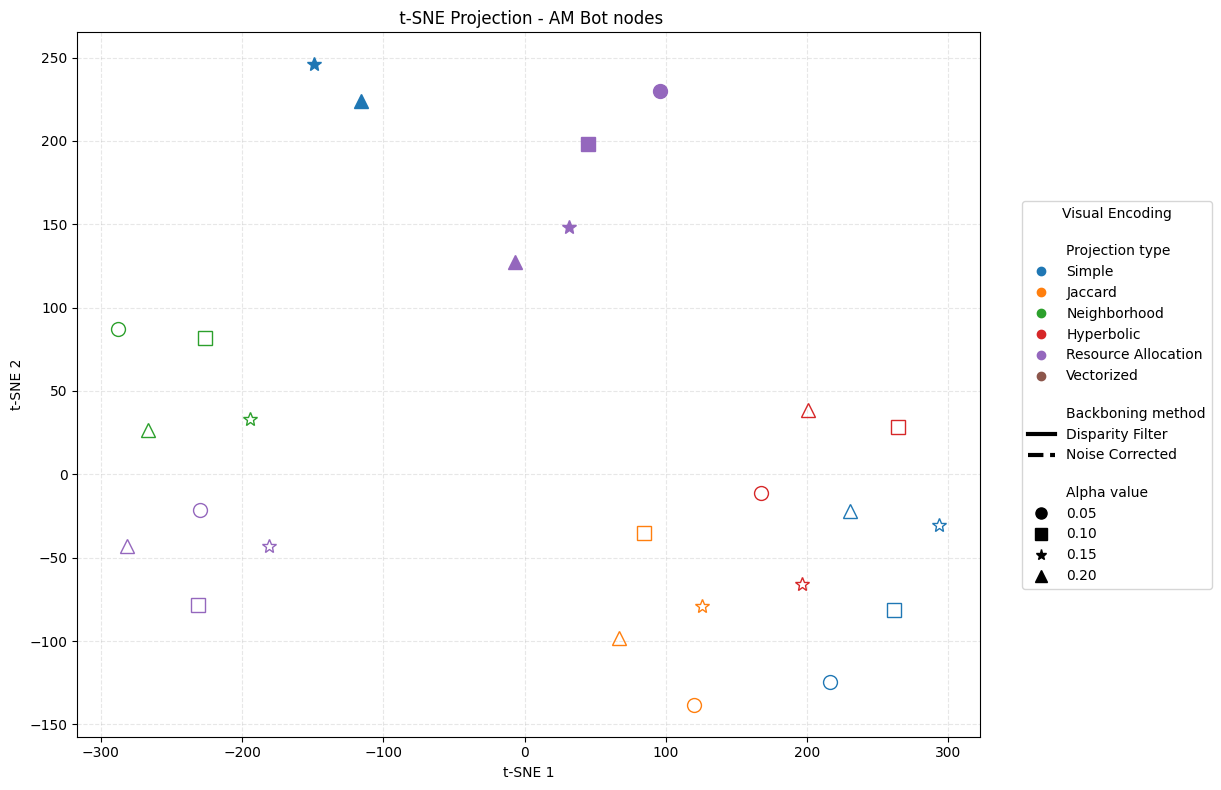

In [25]:
# --- TSNE ---

points = []
labels = []
name_codes = []

for front_idx, front in enumerate(all_fronts):
    for sol in front:
        points.append(sol["f"])
        labels.append(front_idx)
        name_codes.append(sol["filename"].split("_")[2:])  # [proj, bb, alpha]

points = np.array(points)
labels = np.array(labels)

# 2. Aplicar t-SNE solo en 2D
tsne_2d = TSNE(n_components=2, perplexity=10, random_state=1, init='pca', learning_rate='auto')
embedding_2d = tsne_2d.fit_transform(points)

# 3. Crear figura
fig, ax1 = plt.subplots(figsize=(10, 8))

# 4. Graficar 2D con estilo personalizado
for i, (x, y) in enumerate(embedding_2d):
    key_proj, key_bb, key_alpha = name_codes[i]
    color = projection_styles[key_proj]
    marker = alpha_styles[key_alpha]
    fillstyle = backboning_styles2[key_bb]

    ax1.plot(
        x, y,
        marker=marker,
        color=color,
        markersize=10,
        linestyle='None',
        markerfacecolor=color if fillstyle == 'full' else 'none',
        markeredgecolor=color,
        markerfacecoloralt='none',
        fillstyle=fillstyle
    )

if NODETYPE == 0:
    #plt.title(f"Radviz Visualization of Pareto Fronts - {DATASET.upper()} Bot")
    plt.title(" t-SNE Projection - " + DATASET.upper() + " Top nodes")
else:
    plt.title(" t-SNE Projection - " + DATASET.upper() + " Bot nodes")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.grid(True, linestyle="--", alpha=0.3)

# 5. Leyenda personalizada
color_handles = [
    Line2D([0], [0], color=projection_styles[key], marker='o', linestyle='None', label=projection_labels[key])
    for key in projection_styles
]

marker_handles = [
    Line2D([0], [0], color='black', marker=alpha_styles[key], linestyle='None', markersize=8, label=alpha_labels[key])
    for key in alpha_styles
]

fill_handles = [
    Line2D([0], [0], color='black', marker='o', linestyle='None',
           markerfacecolor='black' if fill == 'full' else 'none',
           fillstyle=fill, label=backboning_labels[key])
    for key, fill in backboning_styles2.items()
]

custom_legend = (
    [Line2D([0], [0], color='white', label='\nProjection type')] + color_handles +
    [Line2D([0], [0], color='white', label='\nBackboning method')] + line_handles +
    [Line2D([0], [0], color='white', label='\nAlpha value')] + marker_handles
)


fig.legend(handles=custom_legend, title="Visual Encoding", bbox_to_anchor=(1.02, 0.5), loc="center left")
plt.tight_layout()
plt.savefig(f"{DATASET}-Type{NODETYPE}-tsne.png")
plt.show()


FIN